In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy.physics.units as u
import sympy as sp
import numpy as np
import logging as log
import functools
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
pd.set_option('display.max_columns', None)
%matplotlib inline
from IPython.display import display, HTML

import sys, os, importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import miptlabs as ml
importlib.reload(ml)

importlib.reload(log)
log.basicConfig(level=log.INFO, format='LOG %(message)s', stream=sys.stdout)

sp.Basic.__str__=lambda expr, **settings:ml.PQStrPrinter(settings).doprint(expr)

sp.__version__

'1.1.2.dev'

In [3]:
d_s = ml.pqarray([ml.PQ(3.9*u.mm, sigma=0.05*u.mm), ml.PQ(5.20*u.mm, sigma=0.05*u.mm)])
r_s = d_s/2
g = ml.PQ(9.815*u.m/u.s**2, is_const=True)
ro = ml.PQ(1.2047*u.kg/u.m**3, is_const=True)
mu = ml.PQ(29*u.g/u.mol, is_const=True)
manom_coef = 9.80665*u.pascal
k = 0.2 # Коэффициент наклона трубки ММН
T = ml.PQ(ml.celsium_to_kelvins(24.5), sigma=0.5*u.kelvin)
#lambda_real = ml.PQ(10**-1*u.milli*u.mm, is_const=True)
#print(lambda_real)

Re_laminar = ml.PQ(1000, is_const=True)
a_approx = 0.2*r_s*Re_laminar # Примерное расстояние, с которого начнётся ламинарное течение
print(a_approx.val)
print(a_approx)

[390.0*millimeter 520.0*millimeter]
[390±5 mm (1.3%) 520±5 mm (0.96%)]


In [4]:
data = pd.read_csv('lab1.3.3.csv')
data

,delta_P,sigma_delta_P,delta_V,delta_T,delta_l,delta_P.1,sigma_delta_P.1,delta_V.1,delta_T.1,delta_l.1
0,10,1,0.5,35.00,11.2,10.0,1.0,1.0,26.25,11.5
1,20,1,1.0,37.00,30.0,15.0,1.0,1.0,16.84,30.0
2,30,1,1.0,25.00,40.0,20.0,1.0,1.0,12.87,40.0
3,40,1,1.0,18.50,50.0,25.0,1.0,1.0,10.00,50.0
4,50,1,1.0,14.62,NaN,30.0,1.0,1.0,8.57,NaN
5,60,1,1.0,12.69,NaN,35.0,1.0,1.0,7.46,NaN
6,70,1,1.0,10.91,NaN,40.0,2.0,2.0,14.28,NaN
7,80,2,1.0,9.87,NaN,53.0,2.0,2.0,13.13,NaN
8,93,2,2.0,19.34,NaN,73.0,3.0,2.0,11.97,NaN
9,105,3,2.0,19.14,NaN,93.0,3.0,2.0,10.56,NaN


In [5]:
# Деления
ticks_s = [ml.pqarray([ml.PQ(val, sigma=sigma) for val, sigma in zip(data['delta_P'].dropna().astype(float),
                                                                   data['sigma_delta_P'].dropna().astype(float))]),
           ml.pqarray([ml.PQ(val, sigma=sigma) for val, sigma in zip(data['delta_P.1'].dropna().astype(float),
                                                              data['sigma_delta_P.1'].dropna().astype(float))])]
dP_s = [(ticks*manom_coef*k).repr_as(u.pascal) for ticks in ticks_s]

dV_s = [ml.pqarray([ml.PQ(val*u.liters, epsilon=0.01, dim=u.liters) 
                  for val in data['delta_V'].dropna().astype(float)]),
        ml.pqarray([ml.PQ(val*u.liters, epsilon=0.01, dim=u.liters) 
                  for val in data['delta_V.1'].dropna().astype(float)])]

dT_s = [ml.pqarray([ml.PQ(val*u.seconds, sigma=0.5*u.seconds) 
                  for val in data['delta_T'].dropna().astype(float)]),
        ml.pqarray([ml.PQ(val*u.seconds, sigma=0.5*u.seconds) 
                  for val in data['delta_T.1'].dropna().astype(float)])]

Q_s = [dV/dT for (dV, dT) in zip(dV_s, dT_s)]


delta_l_s = [ml.pqarray([ml.PQ(val*u.cm, sigma=0.1*u.mm) for val in data['delta_l'].dropna().astype(float)]),
             ml.pqarray([ml.PQ(val*u.cm, sigma=0.1*u.mm) for val in data['delta_l.1'].dropna().astype(float)])]
l_s = [np.cumsum(delta_l) for delta_l in delta_l_s]

laminar_border_s = [8, 6]

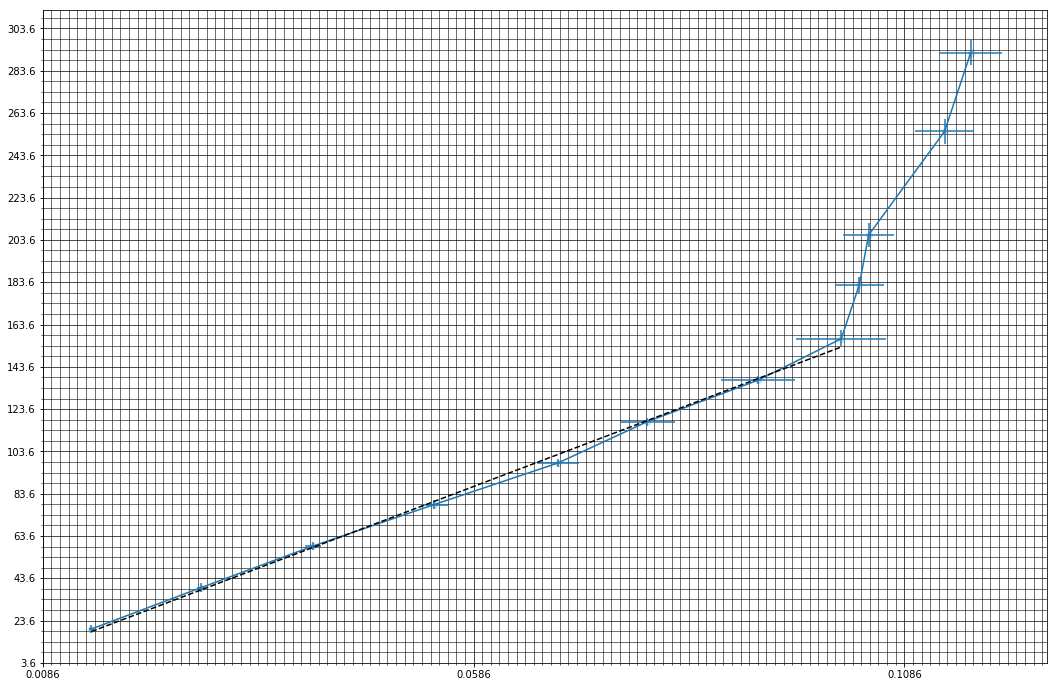

k 1546.07864887
eta (17.6±0.9)*10^-6 Pa*s (5.1%)
Re 1160±70  (6.0%)


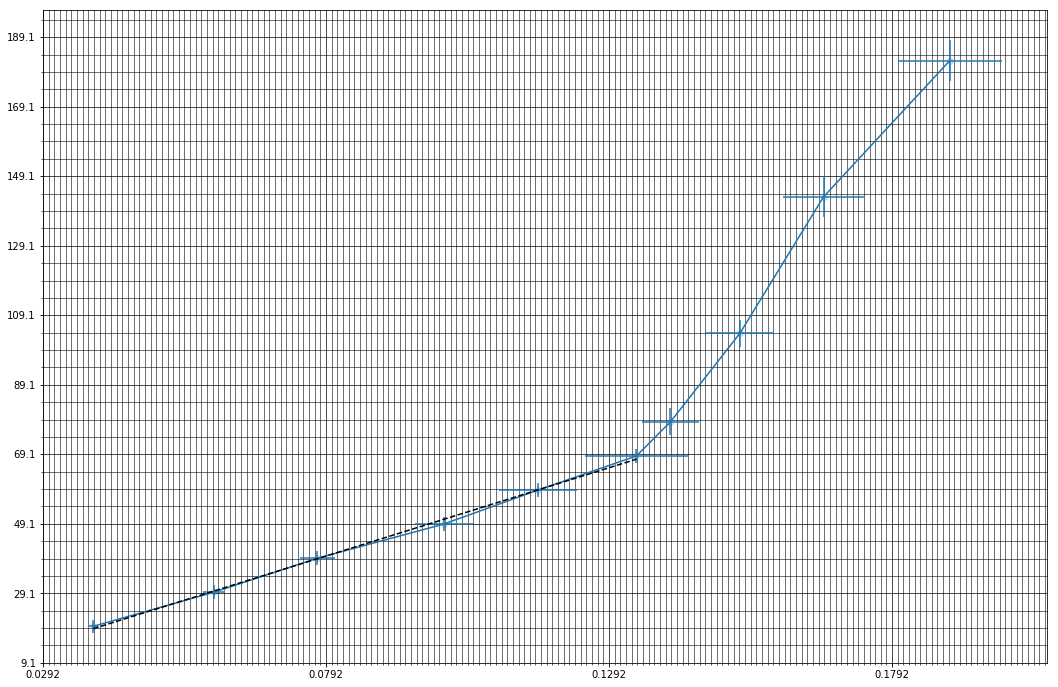

k 508.251092902
eta (18.2±0.7)*10^-6 Pa*s (3.8%)
Re 1130±60  (5.4%)


In [6]:
for Q, dP, dV, dT, r, lens, laminar_border in zip(Q_s, dP_s, dV_s, dT_s, r_s, delta_l_s, laminar_border_s):
    new_data = pd.DataFrame({
        'dP':dP,
        'dV':dV,
        'dT':dT,
        'Q':Q
    })
    l = lens[3]
    plt.figure(figsize=(18, 12))
    ml.plt_pq(Q[:laminar_border+4], dP[:laminar_border+4], grid_x=(0.05, 0.001), grid_y=(20,5))
    ml.plot_OLS(Q[:laminar_border], dP[:laminar_border])
    
    plt.show()
    
    ols_coefs, ols_errors = ml.OLS(Q[:laminar_border], dP[:laminar_border])
    print('k', ols_coefs[0])

    eta = ml.eval(u.pascal*u.s, lambda r, l, coef:np.pi*r**4/(8*l)*coef*(u.pascal*u.s)/u.liters, r, l, ols_coefs[0])
    print('eta', eta)
    
    Re = Q[laminar_border]*ro/(np.pi*r*eta)
    print('Re', Re.repr_as(1))

    # display(new_data)
# Тут смотрим, когда кончается прямая, и отрезаем ненужное

$Re = \frac{\rho v r}{\eta} = \frac{\rho (v \pi r^2)}{\pi r \eta} = \frac{\rho Q}{\pi r \eta}$ — число Рейнольдса. Вычислим его для момента, когда ламинарное течение переходило в турбулентное

$v_T = \sqrt{\frac{3kT}{\mu}}$

In [7]:
# Для переходной области 
# Скорость теплового движения молекул воздуха
v_T = (3*u.molar_gas_constant*T/mu)**(1/2)
print(v_T.repr_as(u.m/u.s))
P = ml.PQ(100258*u.pa, sigma=10*u.pa)
ro = P*mu/(u.R*T)
ro.repr_as(u.kg/u.m**3)
print('rho', ro.val)
eta_theor = 1/3*ro*v_T*(10**(-5))*u.cm
#eta_theor = ro*v_T
print(eta_theor.val)
eta_theor.repr_as(u.kilogram**0.666666666666666*u.meter**(-1.33333333333333)*u.second**(-0.666666666666666))
print(eta_theor.val)
#print(eta_theor.val.n()/eta_theor.dim)
print(eta_theor.dim)
#calculated_radius = [8*l*eta/(np.pi*ols_coefs[0])/(u.pascal*u.s)*u.liter]
#all_r_s = [r]


506.0±0.4 m/s (0.084%)
rho 37.1515647392656*K**(-0.454545454545455)*Pa**0.454545454545455*kg**0.0454545454545455*m**(-0.136363636363636)*mol**(-0.454545454545455)
0.0317345906456416*K**(-0.454545454545455)*kg**(-0.0681818181818181)*m**0.136363636363636*mol**(-0.454545454545455)*s**0.0681818181818181
0.0317345906456416*K**(-0.454545454545455)*kg**(-0.0681818181818181)*m**0.136363636363636*mol**(-0.454545454545455)*s**0.0681818181818181
kg**0.666666666666666*m**(-1.33333333333333)*s**(-0.666666666666666)


In [8]:
# 6. Для гарантированно ламинарного течения измеряем распределение давления вдоль трубки.

In [9]:
Q_exper_s = [ml.PQ(1*u.l/(16.40*u.s), sigma=0.01), ml.PQ(1*u.l/(12.03*u.s), sigma=0.01)]
ticks_s = [ml.pqarray([ml.PQ(val, sigma=1) for val in 
                     [31, 62, 106, 153]]),
           ml.pqarray([ml.PQ(val, sigma=1) for val in 
                     [20, 34, 51, 71]])]
P_s = [(ticks*manom_coef*k).repr_as(u.pascal) for ticks in ticks_s]
print('P:', P_s)

P: [pqarray([60.8±2.0 Pa (3.2%), 121.6±2.0 Pa (1.6%), 207.9±2.0 Pa (0.94%),
         300.1±2.0 Pa (0.65%)], dtype=object), pqarray([39.2±2.0 Pa (5.0%), 66.7±2.0 Pa (2.9%), 100.0±2.0 Pa (2.0%),
         139.3±2.0 Pa (1.4%)], dtype=object)]


[0.00±0.10 Pa (1000000%) 60.8±2.8 Pa (4.6%) 86.3±2.8 Pa (3.2%)
 92.2±2.8 Pa (3.0%)]
[5.600±0.005 cm (0.089%) 26.200±0.011 cm (0.043%) 61.200±0.015 cm (0.025%)
 106.200±0.018 cm (0.017%)]


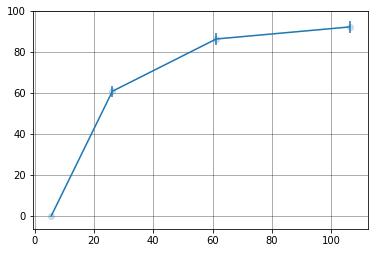

[0.00±0.10 Pa (1000000%) 27.5±2.8 Pa (10%) 33.3±2.8 Pa (8.3%)
 39.2±2.8 Pa (7.1%)]
[5.750±0.005 cm (0.087%) 26.500±0.011 cm (0.042%) 61.500±0.015 cm (0.024%)
 106.500±0.018 cm (0.017%)]


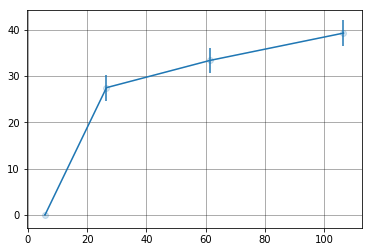

In [10]:
for delta_l, l, P in zip(delta_l_s, l_s, P_s):
    delta_P = ml.pqarray([ml.PQ(0.00001*u.pascals, sigma=0.1*u.pascal, dim=u.pascal)]+list(P[1:]-P[:-1]))
    print(delta_P)
    l_mid = np.array([ml.PQ(0, is_const=True, dim=u.cm)]+list(l[:-1]))+delta_l/2
    print(l_mid)
    ml.plt_pq(l_mid, delta_P)
    plt.show()
    #ml.plt_pq(delta_l, dP)
    #plt.show()
    #ml.plt_pq(l, P)
    #plt.show()